# Via expressa para ônibus urbano

In [1]:
from _thread import *
from IPython.display import IFrame

import time
import random
import threading
import osmnx as ox
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Configuração para o algoritmo genético

In [2]:
totGeracoes  = 500
tamPopulacao = 50

SelecionartipoBusca = 1  # 1-OneMax outro valor DFS

indCruzamento = 5
CXPB = 0.5
MUTPB = 0.15
PROB_MUTACAO = 0.15

recebeAjuda  = False

#pontuação baixo será eliminada do grafo
removerPior = 0


# Formato Imagens

In [3]:
'''
    Formatos Suportados salvar rotas e mapas: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz 
'''
formato_imgs = 'pdf'

# Configuração da Imagens


In [4]:
'''
    configuração da imagens
'''
edge_color = "#000000"     # cor da aresta
bgcolor    = "#D3D3D3"     # cor do background
node_color = "#9370DB"     # cor da vértice
node_size  = 20            # Tamanho do vértice
fig_height = 20            # altura figura
fig_width  = 20            # largura figura

# Localização para a biblioteca OSMNX gerar o Grafo

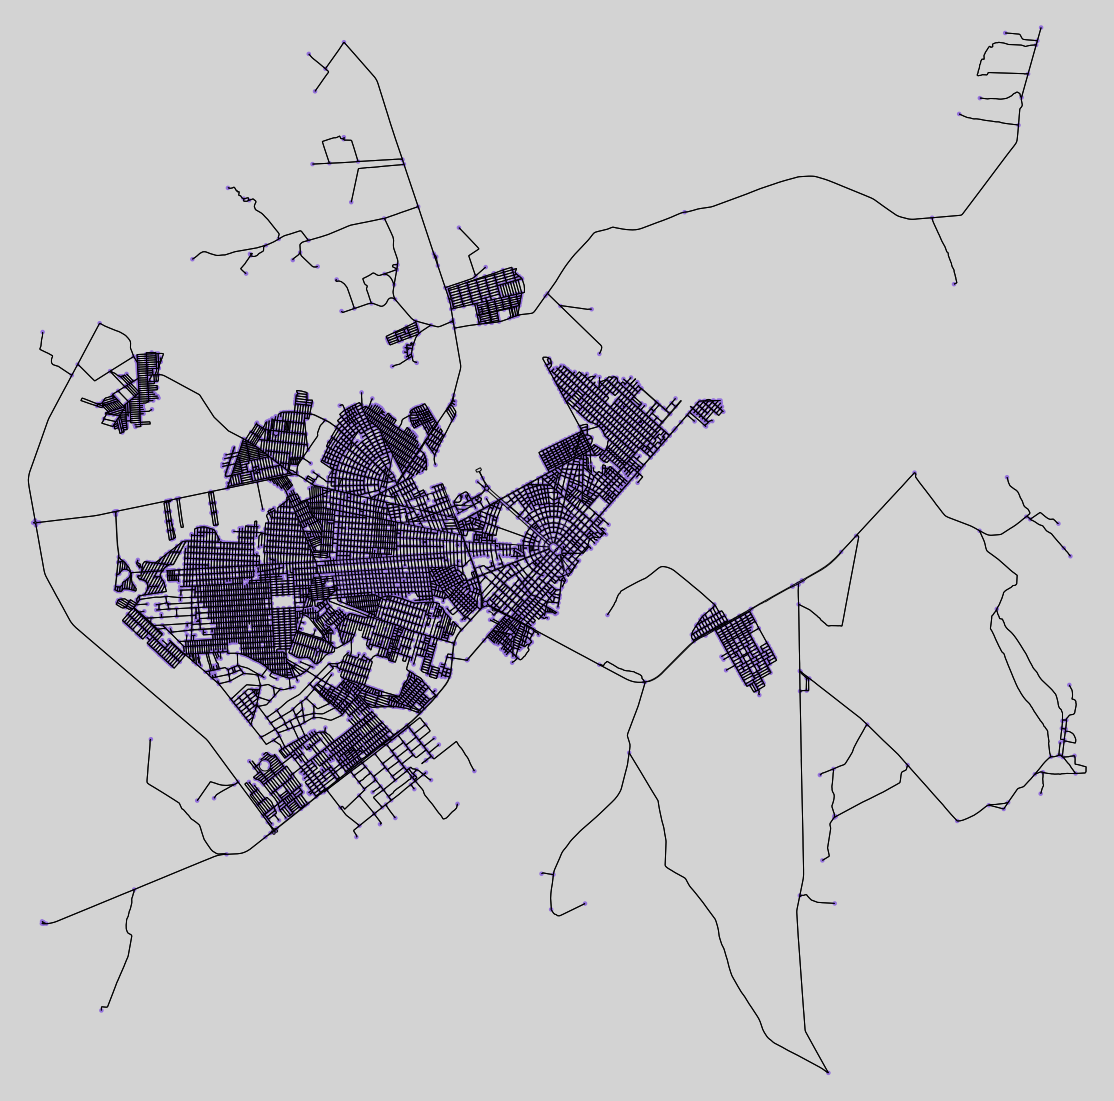

(<Figure size 1440x1440 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f07df985748>)

In [5]:
place = 'Boa Vista, Roraima, BR'
Raio_distancia = 15000

G = ox.graph_from_address( place, network_type='drive', simplify=True, distance=Raio_distancia )

ox.plot_graph(G, fig_height=fig_height, fig_width=fig_width, edge_color=edge_color, bgcolor=bgcolor, node_color=node_color, node_size=node_size, filename="mapaCompleto", save=True, file_format=formato_imgs)

# Vértice que representa o terminal de ônibus

In [6]:
nodosCentroCivico = (3648084763,3648084762)
nodoAdjTerminal   = (3648084763,3589958315)

# Extrai as informações das via do Grafo G

In [7]:
listaDados = []

dado = G.adj
for i in dado:
    for j in dado[i]:
        for k in dado[i][j]:
            #print()
            #print(dado[i][j][k])
            h = []
            h.append(i)
            h.append(j)
            h.append(dado[i][j][k])
            listaDados.append(h)

# Gera uma lista com as pontuações que cada aresta recebeu dentre as suas características

In [8]:
listaValores = []
valorRuim = -1

for i in listaDados:
    soma = 0
    
    if "highway" in i[2]:
        if i[2]['highway'] == "primary": #ex: avenida venezuela
            soma = 1
        elif i[2]['highway'] == "secondary": #ex: Major Williams
            soma = 1
        elif i[2]['highway'] == "tertiary": #ex: Rua General Penha Brasil
            soma = 1
        else:
            soma = valorRuim
    
    
    listaValores.append(soma)


# Separa os vértices que não conseguiram atingir a pontuação mínima para remoção do Grafo

In [9]:
remover = []

for i in range(len(listaValores)):
    if listaValores[i] <= removerPior:
        remover.append( (listaDados[i][0], listaDados[i][1]))
        
G.remove_edges_from(remover)

# Atualiza a lista de arestas que estão aptas a serem selecionadas

In [10]:
listaValoresNew = []
listaDadosNew = []

for i in range(len(listaDados)):
    if listaValores[i] >= removerPior:
        listaValoresNew.append( listaValores[i] )
        listaDadosNew.append( listaDados[i] )

#remover os dados antigos para devolver memória
listaDados.clear()
listaValores.clear()
print(len(listaValoresNew))

6967


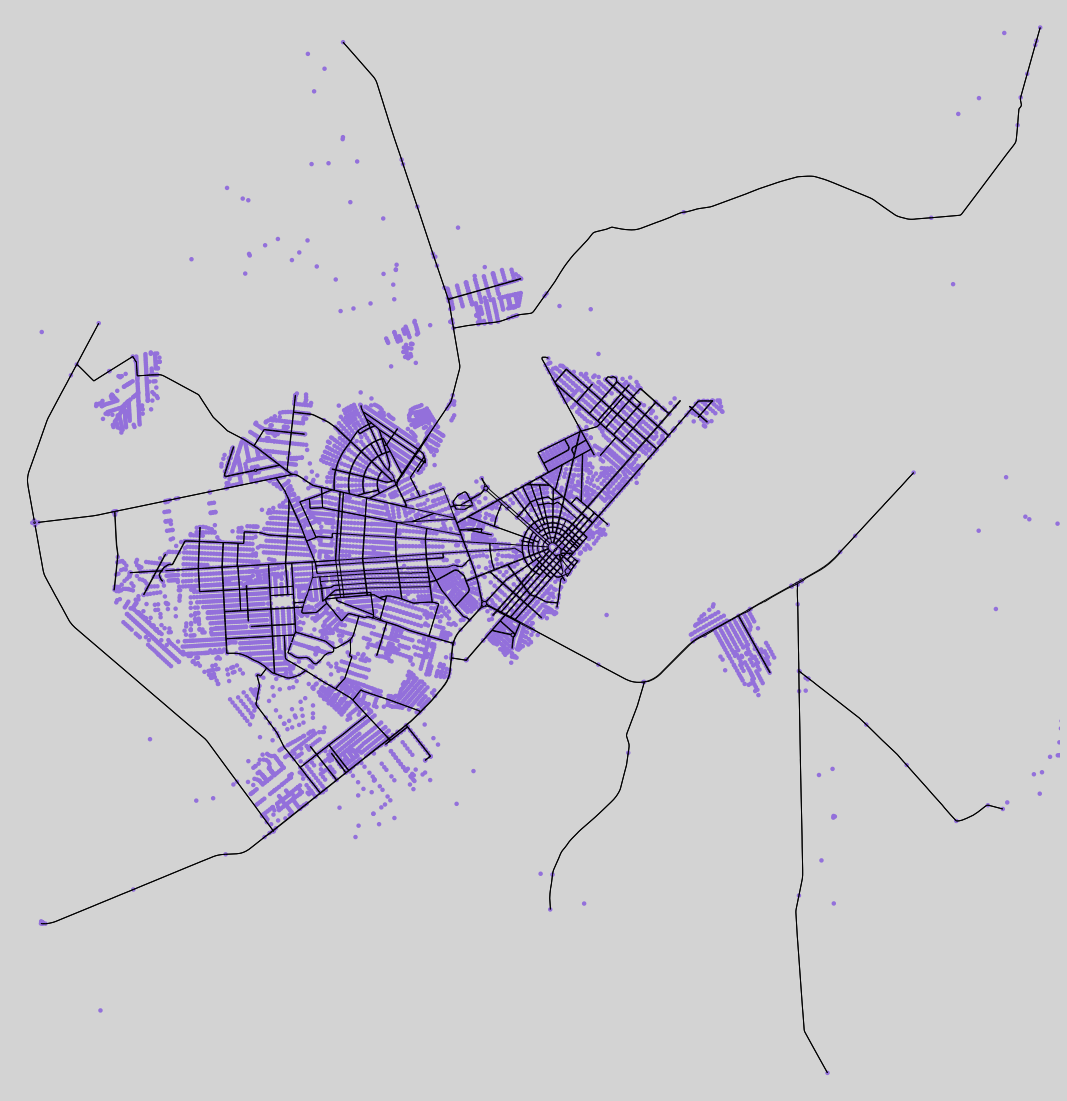

(<Figure size 1440x1440 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f07e613e8d0>)

In [11]:
ox.plot_graph(G, fig_height=fig_height, fig_width=fig_width, edge_color=edge_color, bgcolor=bgcolor, node_color=node_color, node_size=node_size, filename="mapaFiltrado", save=True,  file_format=formato_imgs)

In [12]:
#(3648084763,3648084762)
#t = len(listaDadosNew)
#for i in range(t):
#    print("({},{})".format(listaDadosNew[i][0], listaDadosNew[i][1]))



# Lista que receberá os caminhos encontrados pelo AG

In [13]:
listaResultadoDFS = []
tamanhoDosCiclosSalvos = []

# Lista para salvar as informações da evolução do AG para plotagem de gráfico ao final do experimento

In [14]:
PlotMinDados  = []
PlotMeanDados = []
PlotMaxDados  = []

PlotMaioresCiclos = []
PlotMaioresCiclos.append(0)

In [15]:
parada = False
tamGenes = len(listaValoresNew)

# Busca em profundidade que encontrará os caminhos caso exista

In [16]:
def DFS_BuscaCiclo(grafo, mapa, mapaGrafo, verticeInicial, tamGrafo):
    
    import stack    
    pilha = stack.stack()
    v = verticeInicial
        
    #vetor de marcação de visitados e de elementos que estão na pilha O(1)
    visitados = []
    pilha_rec = []
    
    for i in range(tamGrafo):
        visitados.append(False)
        pilha_rec.append(False)
    
        
    it = -1
    contListaPercorrida = 0
    listaPercorrida = []
    controleMaiorCiclo = PlotMaioresCiclos[-1]
    
    #inicio da BFS
    while True:
        achou_vizinho = False        
        
        listaPercorrida.append(v)
        contListaPercorrida += 1
                
        if not visitados[ mapa[ v ] ]:
            x = mapa[ v ]
            
            pilha.empilhar( x )
            visitados[ x ] = True
            pilha_rec[ x ] = True
            
        for it in grafo[v]:
            
            #se tiver na pilha é porque possue ciclo           
            if it == verticeInicial:
                
                listaArestasCiclo = []
                
                for k in listaPercorrida:
                    if pilha_rec[ mapa[ k ] ] == True:
                        listaArestasCiclo.append( k )
                        
                tamList = len( listaArestasCiclo )
                
                if tamList > controleMaiorCiclo:
                    controleMaiorCiclo = tamList
                    
                    PlotMaioresCiclos.append( controleMaiorCiclo )
                                                        
                    '''
                        Pega o ciclo para salvar
                    '''
                    
                    cicloAtual = []
                    
                    for k in range(1, len(listaArestasCiclo)):
                        cicloAtual.append( (listaArestasCiclo[k-1], listaArestasCiclo[k]) )
                    cicloAtual.append( ( listaArestasCiclo[-1], listaArestasCiclo[0] ) )
                    
                    cicloAtualList = list( cicloAtual )
                    listaResultadoDFS.append( cicloAtualList )
                    tamanhoDosCiclosSalvos.append( tamList )
                    
                    achou_vizinho = False
                    break
                    
                    
            if not visitados[ mapa[ it ] ]:
                achou_vizinho = True
                break
                
        if not achou_vizinho:
            pilha_rec[ pilha.topo() ] = False
                
            pilha.desempilhar()
            
            if pilha.p_vazia():
                break
                
            v = mapaGrafo[ pilha.topo() ]
        
        else:
            v =  it
    
    
    # retorna a quantidade de arestas percorridas
    return contListaPercorrida

# Função que executa um filtro para remover as arestas não selecionadas pelo AG e envia a DFS para validação de rotas

In [17]:
def temCicloDFS(individuo):
    
    G_aux = G.copy()
    
    # ajuda na evolução do onemax
    if recebeAjuda:
        for i in range(100):            
            posicao = random.randint(0,tamGenes-1)
            individuo[posicao] = 1
        
        
                
    #identificador da posicao do nodo centro cívico para verificar se esta ativo
    ja_1 = False
    ja_2 = False
    for i in range(tamGenes):
        if listaDadosNew[i][0] == nodosCentroCivico[0] and listaDadosNew[i][1] == nodosCentroCivico[1]:
            individuo[i] = 1
            ja_1 = True
        if listaDadosNew[i][0] == nodoAdjTerminal[0] and listaDadosNew[i][1] == nodoAdjTerminal[1]:
            individuo[i] = 0
            ja_2 = True
        if ja_1 and ja_2:
            break
            
    
    #lista para remover os nós não selecionados pelo AG
    listaRemover = []            
        
    #Seleção dos nodos não selecionados
    #for i in range(len(individuo)):
    for i in range(tamGenes):
        if individuo[i] == 0:
            listaRemover.append( (listaDadosNew[i][0], listaDadosNew[i][1]) )
            
    #Remove os nodos não selecionados pelo AG
    G_aux.remove_edges_from( listaRemover )
    
    
    
    #listaMapa recebe os valores de [0 a totNodos]
    listaMapa = []
    for i in range(len(G_aux.nodes)):
        listaMapa.append(i)
    
    
    # 215151515 --> 10
    mapa = pd.Series(index=G_aux.nodes, data=listaMapa)
    # 10 --> 215151515
    mapaGrafo = pd.Series(G_aux.nodes)
    
    resposta = DFS_BuscaCiclo(G_aux, mapa, mapaGrafo, nodosCentroCivico[0], len(G_aux.nodes))
    
    if SelecionartipoBusca == 1:
        return np.sum(individuo)
    else:
        return resposta

# DEAP - ONEMAX

In [18]:
log_evolution_GA = []

In [ ]:
import array
import random

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
random.seed(64)

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", array.array, typecode='b', fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Attribute generator
toolbox.register("attr_bool", random.randint, 0, 1)

# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, tamGenes)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evalOneMax(individual):
    return temCicloDFS(individual),

toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=PROB_MUTACAO)
toolbox.register("select", tools.selTournament, tournsize=indCruzamento)

def main():
    pop = toolbox.population(n=tamPopulacao)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)
    
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=totGeracoes, 
                                   stats=stats, halloffame=hof, verbose=True)
    
    log_evolution_GA.append(log)
    
    return pop, log, hof

if __name__ == "__main__":
    main()

gen	nevals	avg    	min 	max 
0  	50    	3495.32	3429	3575
1  	32    	3534.2 	3453	3603
2  	22    	3558.32	3520	3603
3  	25    	3569.56	3482	3603
4  	40    	3589.72	3541	3644
5  	34    	3605.96	3533	3655
6  	29    	3631.92	3582	3669
7  	27    	3646.28	3580	3680
8  	23    	3657.16	3567	3700
9  	34    	3673.4 	3623	3702
10 	30    	3674.86	3579	3702
11 	14    	3690.98	3579	3708
12 	22    	3693.26	3615	3708
13 	35    	3690.5 	3584	3715
14 	32    	3700.38	3599	3715
15 	31    	3698.94	3575	3726
16 	33    	3707.1 	3622	3736
17 	36    	3705.88	3580	3736
18 	26    	3714.62	3616	3736
19 	26    	3722.74	3646	3736
20 	26    	3727.02	3585	3736
21 	25    	3726.8 	3603	3736
22 	21    	3723.46	3639	3736
23 	26    	3723.08	3624	3736
24 	26    	3727.78	3623	3736
25 	31    	3730.06	3602	3736
26 	25    	3728.28	3621	3736
27 	28    	3721.22	3584	3736
28 	29    	3725.24	3587	3736
29 	27    	3731.06	3629	3736
30 	27    	3722.36	3636	3736
31 	36    	3726.34	3622	3736
32 	27    	3723.46	3628	3736
33 	28    	372

282	33    	3821.48	3678	3838
283	37    	3816.6 	3691	3838
284	26    	3820.34	3675	3838
285	29    	3821.16	3685	3838
286	32    	3822.36	3687	3838
287	38    	3804.38	3679	3838
288	24    	3819.7 	3677	3838
289	30    	3833.52	3766	3838
290	27    	3814.48	3690	3838
291	24    	3820.6 	3688	3838
292	27    	3823.42	3698	3838
293	33    	3815.8 	3691	3838
294	28    	3822.48	3697	3838
295	29    	3817.96	3693	3838
296	30    	3814.02	3664	3838
297	27    	3825.08	3682	3838
298	29    	3820.82	3690	3838
299	27    	3829.12	3703	3838
300	29    	3825.02	3708	3838
301	33    	3825.58	3687	3838
302	30    	3821.34	3692	3838
303	31    	3812.28	3665	3838
304	33    	3832.6 	3680	3838
305	25    	3819.08	3700	3838
306	32    	3811.3 	3692	3838
307	23    	3821.14	3692	3838
308	26    	3824.34	3693	3838
309	31    	3820.16	3689	3838
310	25    	3829.84	3751	3838
311	29    	3827.1 	3705	3838
312	35    	3816.26	3692	3838
313	31    	3829.04	3706	3838
314	41    	3823.32	3693	3838
315	28    	3830.32	3720	3838
316	32    	382

In [ ]:
for dado in log_evolution_GA:
    for dado_i in dado:
        minimo  = int(dado_i['min'])
        media   = int(dado_i['avg'])
        maximo  = int(dado_i['max'])
        
        PlotMinDados.append(minimo)
        PlotMeanDados.append(media)
        PlotMaxDados.append(maximo)

# Gráfico da Evolução do AG dentre as gerações com máximo, média e mínimo

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(PlotMaxDados, 'ob--' , label='MAX')
plt.plot(PlotMeanDados, 'or--' ,label='MEAN')
plt.plot(PlotMinDados, 'og--',label='MIN')
plt.xlabel('i-ésima Geração')
plt.ylabel('Onemax - Quantidade Arestas Selecionadas')
plt.title('Evolution GA - Quantidade de Arestas Selecionadas')
plt.legend(loc='upper left')
plt.savefig("images/0-graficoEvolucaoOnemax.pdf",format=formato_imgs)

# Evolução dos ciclos

In [ ]:
#
# Evolução dos ciclos encontrados
plt.figure(figsize=(16,9))
plt.plot(PlotMaioresCiclos, 'ob--' , label='Ciclos')
plt.xlabel('i-ésimo ciclo validado')
plt.ylabel('Número de arestas nos ciclos')
plt.title('Evolução dos ciclos validados')
plt.legend(loc='upper left')
plt.savefig("images/0-GraficoTamanhoDosCiclos.pdf",format=formato_imgs)
#plt.show()

# Plotagem das rotas geradas caso tenha encontrado

In [ ]:
def salvarRotaTxt(via_vez, rota):
    path = "Rotas/Rota-"+str(via_vez)+".txt"
    arq = open(path, 'w')    
    for linha in rota:
        arq.write(linha+"\n")        
    arq.close()

    
def printFormatNamesStreet( via_vez , qtd_arestas, ruas ):
    
    contador = 1
    salvarText = []
    
    # +1 por causa do retorno do ciclo da rota    
    Rota = "Rota "+str(via_vez)+" - "+str(qtd_arestas)+" Arestas:\n"
    print(Rota)
    salvarText.append(Rota)
    
    for rua in ruas:
        concat = str(rua)
        Rua = ""+str(contador)+"ª - "+concat
        print(Rua)
        salvarText.append(Rua)
        contador = contador + 1
    
    Rua = ""+str(contador)+"ª - "+ruas[0]
    print(Rua)
    salvarText.append(Rua)
    
    salvarRotaTxt(via_vez, salvarText)
        
        
def printRotaRuas(via_vez, qtd_arestas, rota ):
    
    try:
                
        tamListaDadosNew = len(listaDadosNew)
        tamRotaLista = len(rota)

        ruasRota = []
        
        for rota_i in range( tamRotaLista ):            
            for lista_i in range(tamListaDadosNew):            
                if( listaDadosNew[lista_i][0] == rota[rota_i][0] and listaDadosNew[lista_i][1] == rota[rota_i][1] ):
                    
                    if 'name' in listaDadosNew[lista_i][2]:
                        rua = listaDadosNew[lista_i][2]['name']

                        if rua not in ruasRota:
                            ruasRota.append(rua)
                            
                    else:
                        ruasRota.append("Unname")

                                     
        
        printFormatNamesStreet(via_vez, qtd_arestas, ruasRota )
        print("\n\n")
    
    except:
        print("Erro...")

In [ ]:
removerNodosFinal = []
cont=1
contador = 1
if len(listaResultadoDFS) > 0:
    for cadaCicloEncontrado in range(len(listaResultadoDFS)):
        
        name = "0-Rota-"+ str(contador)

        arestas_sel = listaResultadoDFS[cadaCicloEncontrado]

        path = [ (u,v) for (u,v, attr) in G.edges(data=True) if (u,v) in arestas_sel]

        ox.plot.plot_graph_routes(G, path, show=True, fig_height=fig_height, fig_width=fig_width, bgcolor=bgcolor, route_alpha=1, route_linewidth=2, node_size=0 , orig_dest_node_alpha=0, filename=name, save=True,  file_format=formato_imgs )
        print("\n")

        printRotaRuas( contador, PlotMaioresCiclos[contador] , listaResultadoDFS[cadaCicloEncontrado] )
        contador = contador + 1
        
else:
    print("Infelizmente não foi possivel encontrar uma rota....")

# FIMMM --- Obrigado